In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
import itertools
from keras.utils import plot_model
from keras.layers import Input, Dense, Reshape, Flatten
from keras import layers, initializers
from keras.models import Model, load_model
import keras.backend as K
import numpy as np
from seqtools import SequenceTools as ST
from util import AA, AA_IDX
from util import build_vae
from sklearn.model_selection import train_test_split, ShuffleSplit
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import scipy.stats
from scipy.stats import norm
from scipy.optimize import minimize
from keras.utils.generic_utils import get_custom_objects
from util import one_hot_encode_aa, partition_data, get_balaji_predictions, get_samples
from util import convert_idx_array_to_aas, build_pred_vae_model, get_experimental_X_y, count_substring_mismatch
from util import get_gfp_X_y_aa, load_gfp_data, one_hot_encode_aa, one_hot_encode, get_all_amino_acids, get_wild_type_amino_acid_sequence
from losses import neg_log_likelihood
import json
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

Using TensorFlow backend.


In [2]:
def build_model(M):
    x = Input(shape=(M, 20,))
    y = Flatten()(x)
    y = Dense(50, activation='elu')(y)
    y = Dense(2)(y)
    model = Model(inputs=x, outputs=y)
    return model

def evaluate_ground_truth(X_aa, ground_truth, save_file=None):
    y_gt = ground_truth.predict(X_aa, print_every=100000)[:, 0]
    if save_file is not None:
        np.save(save_file, y_gt)
        
def train_and_save_oracles(X_train, y_train, n=10, suffix='', batch_size=100):
    for i in range(n):
        model = build_model(X_train.shape[1])
        model.compile(optimizer='adam',
                      loss=neg_log_likelihood,
                      )
        early_stop = EarlyStopping(monitor='val_loss', 
                                   min_delta=0, 
                                   patience=5, 
                                   verbose=1)

        model.fit(X_train, y_train, 
                  epochs=100, 
                  batch_size=batch_size, 
                  validation_split=0.1, 
                  callbacks=[early_stop],
                  verbose=2)
        model.save("models/oracle_%i%s.h5" % (i, suffix))

In [3]:
def weighted_ml_opt(X_train, oracles, ground_truth, vae_0, weights_type='dbas',
        LD=20, iters=20, samples=500, homoscedastic=False, homo_y_var=0.1,
        quantile=0.95, verbose=False, alpha=1, train_gt_evals=None,
        cutoff=1e-6, it_epochs=10, enc1_units=50):
    
    assert weights_type in ['cbas', 'dbas','rwr', 'cem-pi', 'fbvae']
    L = X_train.shape[1]
    vae = build_vae(latent_dim=LD,
                    n_tokens=20, seq_length=L,
                    enc1_units=enc1_units)

    traj = np.zeros((iters, 7))
    oracle_samples = np.zeros((iters, samples))
    gt_samples = np.zeros((iters, samples))
    oracle_max_seq = None
    oracle_max = -np.inf
    gt_of_oracle_max = -np.inf
    y_star = - np.inf
    for t in range(iters):
        ### Take Samples ###
        zt = np.random.randn(samples, LD)
        if t > 0:
            Xt_p = vae.decoder_.predict(zt)
            Xt = get_samples(Xt_p)
        else:
            Xt = X_train
        
        ### Evaluate ground truth and oracle ###
        yt, yt_var = get_balaji_predictions(oracles, Xt)
        if homoscedastic:
            yt_var = np.ones_like(yt) * homo_y_var
        Xt_aa = np.argmax(Xt, axis=-1)
        if t == 0 and train_gt_evals is not None:
            yt_gt = train_gt_evals
        else:
            yt_gt = ground_truth.predict(Xt_aa, print_every=1000000)[:, 0]
        
        ### Calculate weights for different schemes ###
        if t > 0:
            if weights_type == 'cbas': 
                log_pxt = np.sum(np.log(Xt_p) * Xt, axis=(1, 2))
                X0_p = vae_0.decoder_.predict(zt)
                log_px0 = np.sum(np.log(X0_p)*Xt, axis=(1, 2))
                w1 = np.exp(log_px0-log_pxt)
                y_star_1 = np.percentile(yt, quantile*100)
                if y_star_1 > y_star:
                    y_star = y_star_1
                w2= scipy.stats.norm.sf(y_star, loc=yt, scale=np.sqrt(yt_var))
                weights = w1*w2 
            elif weights_type == 'cem-pi':
                pi = scipy.stats.norm.sf(max_train_gt, loc=yt, scale=np.sqrt(yt_var))
                pi_thresh = np.percentile(pi, quantile*100)
                weights = (pi > pi_thresh).astype(int)
            elif weights_type == 'dbas':
                y_star_1 = np.percentile(yt, quantile*100)
                if y_star_1 > y_star:
                    y_star = y_star_1
                weights = scipy.stats.norm.sf(y_star, loc=yt, scale=np.sqrt(yt_var))
            elif weights_type == 'rwr':
                weights = np.exp(alpha*yt)
                weights /= np.sum(weights)
#             elif weights_type == ''
        else:
            weights = np.ones(yt.shape[0])
            max_train_gt = np.max(yt_gt)
            
        yt_max_idx = np.argmax(yt)
        yt_max = yt[yt_max_idx]
        if yt_max > oracle_max:
            oracle_max = yt_max
            try:
                oracle_max_seq = convert_idx_array_to_aas(Xt_aa[yt_max_idx-1:yt_max_idx])[0]
            except IndexError:
                print(Xt_aa[yt_max_idx-1:yt_max_idx])
            gt_of_oracle_max = yt_gt[yt_max_idx]
        
        ### Record and print results ##
        if t == 0:
            rand_idx = np.random.randint(0, len(yt), samples)
            oracle_samples[t, :] = yt[rand_idx]
            gt_samples[t, :] = yt_gt[rand_idx]
        if t > 0:
            oracle_samples[t, :] = yt
            gt_samples[t, :] = yt_gt
        
        traj[t, 0] = np.max(yt_gt)
        traj[t, 1] = np.mean(yt_gt)
        traj[t, 2] = np.std(yt_gt)
        traj[t, 3] = np.max(yt)
        traj[t, 4] = np.mean(yt)
        traj[t, 5] = np.std(yt)
        traj[t, 6] = np.mean(yt_var)
        
        if verbose:
            print(weights_type.upper(), t, traj[t, 0], color.BOLD + str(traj[t, 1]) + color.END, 
                  traj[t, 2], traj[t, 3], color.BOLD + str(traj[t, 4]) + color.END, traj[t, 5], traj[t, 6])
        
        ### Train model ###
        if t == 0:
            vae.encoder_.set_weights(vae_0.encoder_.get_weights())
            vae.decoder_.set_weights(vae_0.decoder_.get_weights())
            vae.vae_.set_weights(vae_0.vae_.get_weights())
        else:
            cutoff_idx = np.where(weights < cutoff)
            Xt = np.delete(Xt, cutoff_idx, axis=0)
            yt = np.delete(yt, cutoff_idx, axis=0)
            weights = np.delete(weights, cutoff_idx, axis=0)
            vae.fit([Xt], [Xt, np.zeros(Xt.shape[0])],
                  epochs=it_epochs,
                  batch_size=10,
                  shuffle=False,
                  sample_weight=[weights, weights],
                  verbose=0)
            
    max_dict = {'oracle_max' : oracle_max, 
                'oracle_max_seq': oracle_max_seq, 
                'gt_of_oracle_max': gt_of_oracle_max}
    return traj, oracle_samples, gt_samples, max_dict


In [4]:
def fb_opt(X_train, oracles, ground_truth, vae_0, weights_type='fbvae',
        LD=20, iters=20, samples=500, 
        quantile=0.8, verbose=False, train_gt_evals=None,
        it_epochs=10, enc1_units=50):
    
    assert weights_type in ['fbvae']
    L = X_train.shape[1]
    vae = build_vae(latent_dim=LD,
                    n_tokens=20, seq_length=L,
                    enc1_units=enc1_units)

    traj = np.zeros((iters, 7))
    oracle_samples = np.zeros((iters, samples))
    gt_samples = np.zeros((iters, samples))
    oracle_max_seq = None
    oracle_max = -np.inf
    gt_of_oracle_max = -np.inf
    y_star = - np.inf
    for t in range(iters):
        ### Take Samples and evaluate ground truth and oracle ##
        zt = np.random.randn(samples, LD)
        if t > 0:
            Xt_sample_p = vae.decoder_.predict(zt)
            Xt_sample = get_samples(Xt_sample_p)
            yt_sample, _ = get_balaji_predictions(oracles, Xt_sample)
            Xt_aa_sample = np.argmax(Xt_sample, axis=-1)
            yt_gt_sample = ground_truth.predict(Xt_aa_sample, print_every=1000000)[:, 0]
        else:
            Xt = X_train
            yt, _ = get_balaji_predictions(oracles, Xt)
            Xt_aa = np.argmax(Xt, axis=-1)
            fb_thresh = np.percentile(yt, quantile*100)
            if train_gt_evals is not None:
                yt_gt = train_gt_evals
            else:
                yt_gt = ground_truth.predict(Xt_aa, print_every=1000000)[:, 0]
        
        ### Calculate threshold ###
        if t > 0:
            threshold_idx = np.where(yt_sample >= fb_thresh)[0]
            n_top = len(threshold_idx)
            sample_arrs = [Xt_sample, yt_sample, yt_gt_sample, Xt_aa_sample]
            full_arrs = [Xt, yt, yt_gt, Xt_aa]
            
            for l in range(len(full_arrs)):
                sample_arr = sample_arrs[l]
                full_arr = full_arrs[l]
                sample_top = sample_arr[threshold_idx]
                full_arr = np.concatenate([sample_top, full_arr])
                full_arr = np.delete(full_arr, range(full_arr.shape[0]-n_top, full_arr.shape[0]), axis=0)
                full_arrs[l] = full_arr
            Xt, yt, yt_gt, Xt_aa = full_arrs
        yt_max_idx = np.argmax(yt)
        yt_max = yt[yt_max_idx]
        if yt_max > oracle_max:
            oracle_max = yt_max
            try:
                oracle_max_seq = convert_idx_array_to_aas(Xt_aa[yt_max_idx-1:yt_max_idx])[0]
            except IndexError:
                print(Xt_aa[yt_max_idx-1:yt_max_idx])
            gt_of_oracle_max = yt_gt[yt_max_idx]
        
        ### Record and print results ##

        rand_idx = np.random.randint(0, len(yt), samples)
        oracle_samples[t, :] = yt[rand_idx]
        gt_samples[t, :] = yt_gt[rand_idx]

        traj[t, 0] = np.max(yt_gt)
        traj[t, 1] = np.mean(yt_gt)
        traj[t, 2] = np.std(yt_gt)
        traj[t, 3] = np.max(yt)
        traj[t, 4] = np.mean(yt)
        traj[t, 5] = np.std(yt)
        if t > 0:
            traj[t, 6] = n_top
        else:
            traj[t, 6] = 0
        
        if verbose:
            print(weights_type.upper(), t, traj[t, 0], color.BOLD + str(traj[t, 1]) + color.END, 
                  traj[t, 2], traj[t, 3], color.BOLD + str(traj[t, 4]) + color.END, traj[t, 5], traj[t, 6])
        
        ### Train model ###
        if t == 0:
            vae.encoder_.set_weights(vae_0.encoder_.get_weights())
            vae.decoder_.set_weights(vae_0.decoder_.get_weights())
            vae.vae_.set_weights(vae_0.vae_.get_weights())
        else:
        
            vae.fit([Xt], [Xt, np.zeros(Xt.shape[0])],
                  epochs=1,
                  batch_size=10,
                  shuffle=False,
                  verbose=0)
            
    max_dict = {'oracle_max' : oracle_max, 
                'oracle_max_seq': oracle_max_seq, 
                'gt_of_oracle_max': gt_of_oracle_max}
    return traj, oracle_samples, gt_samples, max_dict


In [5]:
def train_experimental_oracles():
    TRAIN_SIZE = 5000
    train_size_str = "%ik" % (TRAIN_SIZE/1000)
    i = 1
    num_models = [1, 5, 20]
    for i in range(len(num_models)):
        RANDOM_STATE = i+1
        nm = num_models[i]
        X_train, y_train, _  = get_experimental_X_y(random_state=RANDOM_STATE, train_size=TRAIN_SIZE)
        suffix = '_%s_%i_%i' % (train_size_str, nm, RANDOM_STATE)
        train_and_save_oracles(X_train, y_train, batch_size=10, n=nm, suffix=suffix)

In [6]:
def train_experimental_vaes():
    TRAIN_SIZE = 5000
    train_size_str = "%ik" % (TRAIN_SIZE/1000)
    suffix = '_%s' % train_size_str
    for i in [0, 2]:
        RANDOM_STATE = i + 1
        X_train, _, _  = get_experimental_X_y(random_state=RANDOM_STATE, train_size=TRAIN_SIZE)
        vae_0 = build_vae(latent_dim=20,
                  n_tokens=20, 
                  seq_length=X_train.shape[1],
                  enc1_units=50)
        vae_0.fit([X_train], [X_train, np.zeros(X_train.shape[0])],
                  epochs=100,
                  batch_size=10,
                  verbose=2)
        vae_0.encoder_.save_weights("models/vae_0_encoder_weights%s_%i.h5"% (suffix, RANDOM_STATE))
        vae_0.decoder_.save_weights("models/vae_0_decoder_weights%s_%i.h5"% (suffix, RANDOM_STATE))
        vae_0.vae_.save_weights("models/vae_0_vae_weights%s_%i.h5"% (suffix, RANDOM_STATE))

In [7]:
TRAIN_SIZE = 1100
RANDOM_STATE = 1
X_train, _, _, _  = load_gfp_data("../../data/gfp_amino_acid_shuffle_")
X_train = one_hot_encode(X_train[0:TRAIN_SIZE], get_all_amino_acids())
X_train = X_train.reshape(X_train.shape[0], -1, len(get_all_amino_acids()))

In [8]:
from keras.callbacks import History 
history = History()
epochs = 100
vae_0 = build_vae(latent_dim=20,
                  n_tokens=21, 
                  seq_length=X_train.shape[1],
                  enc1_units=50)
vae_0.fit([X_train], [X_train, np.zeros(X_train.shape[0])],
          epochs=epochs,
          batch_size=10,
          verbose=True, callbacks=[history], 
         validation_split = 0.1)
vae_0.encoder_.save_weights("models/vae_0_encoder_weights_{0}.h5".format(epochs))
vae_0.decoder_.save_weights("models/vae_0_decoder_weights_{0}.h5".format(epochs))
vae_0.vae_.save_weights("models/vae_0_vae_weights_{0}.h5".format(epochs))

Train on 990 samples, validate on 110 samples
Epoch 1/100
990/990 [==============================] - 3s 3ms/step - loss: 145.5428 - decoder_loss: 112.5334 - kl_reshape_loss: 33.0094 - val_loss: 45.3359 - val_decoder_loss: 32.4940 - val_kl_reshape_loss: 12.8419
Epoch 2/100
990/990 [==============================] - 2s 2ms/step - loss: 41.6371 - decoder_loss: 31.6036 - kl_reshape_loss: 10.0334 - val_loss: 37.7382 - val_decoder_loss: 28.5228 - val_kl_reshape_loss: 9.2154
Epoch 3/100
990/990 [==============================] - 2s 2ms/step - loss: 35.9248 - decoder_loss: 29.0358 - kl_reshape_loss: 6.8890 - val_loss: 34.3560 - val_decoder_loss: 27.5166 - val_kl_reshape_loss: 6.8394
Epoch 4/100
990/990 [==============================] - 2s 2ms/step - loss: 34.0442 - decoder_loss: 27.5965 - kl_reshape_loss: 6.4477 - val_loss: 32.3605 - val_decoder_loss: 27.1479 - val_kl_reshape_loss: 5.2126
Epoch 5/100
990/990 [==============================] - 2s 2ms/step - loss: 33.5253 - decoder_loss: 26.970

990/990 [==============================] - 2s 2ms/step - loss: 22.9111 - decoder_loss: 22.6474 - kl_reshape_loss: 0.2638 - val_loss: 23.8746 - val_decoder_loss: 23.7447 - val_kl_reshape_loss: 0.1299
Epoch 40/100
990/990 [==============================] - 2s 2ms/step - loss: 22.9709 - decoder_loss: 22.6851 - kl_reshape_loss: 0.2858 - val_loss: 23.8749 - val_decoder_loss: 23.7412 - val_kl_reshape_loss: 0.1336
Epoch 41/100
990/990 [==============================] - 2s 2ms/step - loss: 22.8926 - decoder_loss: 22.5923 - kl_reshape_loss: 0.3002 - val_loss: 23.8530 - val_decoder_loss: 23.6950 - val_kl_reshape_loss: 0.1581
Epoch 42/100
990/990 [==============================] - 2s 2ms/step - loss: 22.7853 - decoder_loss: 22.4732 - kl_reshape_loss: 0.3121 - val_loss: 23.8464 - val_decoder_loss: 23.7068 - val_kl_reshape_loss: 0.1397
Epoch 43/100
990/990 [==============================] - 2s 2ms/step - loss: 22.8302 - decoder_loss: 22.4693 - kl_reshape_loss: 0.3609 - val_loss: 23.8234 - val_decod

990/990 [==============================] - 2s 2ms/step - loss: 21.5753 - decoder_loss: 19.2994 - kl_reshape_loss: 2.2759 - val_loss: 25.0617 - val_decoder_loss: 24.0210 - val_kl_reshape_loss: 1.0406
Epoch 78/100
990/990 [==============================] - 2s 2ms/step - loss: 21.3775 - decoder_loss: 19.1346 - kl_reshape_loss: 2.2429 - val_loss: 25.0865 - val_decoder_loss: 23.7348 - val_kl_reshape_loss: 1.3517
Epoch 79/100
990/990 [==============================] - 2s 2ms/step - loss: 21.4053 - decoder_loss: 19.0249 - kl_reshape_loss: 2.3804 - val_loss: 25.0180 - val_decoder_loss: 23.7940 - val_kl_reshape_loss: 1.2241
Epoch 80/100
990/990 [==============================] - 2s 2ms/step - loss: 21.2319 - decoder_loss: 18.8626 - kl_reshape_loss: 2.3693 - val_loss: 25.2722 - val_decoder_loss: 24.1776 - val_kl_reshape_loss: 1.0946
Epoch 81/100
990/990 [==============================] - 2s 2ms/step - loss: 21.3725 - decoder_loss: 18.8553 - kl_reshape_loss: 2.5172 - val_loss: 25.2916 - val_decod

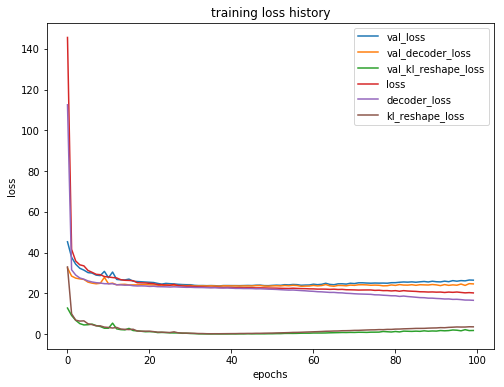

In [9]:
plt.figure(figsize = (8, 6))
for loss in history.history.keys():
    plt.plot(history.history[loss], label=loss)
plt.legend()
plt.title("training loss history")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.savefig("./logs/base_vae_{0}_epochs_training_history.png".format(epochs))

In [10]:
vae_1 = build_vae(latent_dim=20,
                  n_tokens=21, 
                  seq_length=X_train.shape[1],
                  enc1_units=50)
vae_1.encoder_.load_weights("models/vae_0_encoder_weights_{0}.h5".format(epochs))
vae_1.decoder_.load_weights("models/vae_0_decoder_weights_{0}.h5".format(epochs))
vae_1.vae_.load_weights("models/vae_0_vae_weights_{0}.h5".format(epochs))

output_mean_0, output_var_0 = vae_0.encoder_.predict([X_train])
output_mean_1, output_var_1 = vae_1.encoder_.predict([X_train])
np.testing.assert_array_equal(output_mean_0, output_mean_1)
np.testing.assert_array_equal(output_var_0, output_var_1)
z = np.random.sample((1000, 20))
recon_0 = vae_0.decoder_.predict(z)
recon_1 = vae_1.decoder_.predict(z)
np.testing.assert_array_equal(recon_0, recon_1)

In [11]:
vocabulary = get_all_amino_acids()
num_characters = len(vocabulary)
index_to_character = dict(zip(range(num_characters), vocabulary))
wild_type = get_wild_type_amino_acid_sequence()

FileNotFoundError: File b'./data/gfp_data.csv' does not exist

In [ ]:
num_samples = 1000
z = np.random.sample((num_samples, 20))
outputs = vae_1.decoder_.predict(z)
mismatches, all_strings = [], []
for i in range(outputs.shape[0]):
    string = []
    for j in range(outputs.shape[1]):
        k = np.random.choice(list(range(num_characters)), p = outputs[i, j])
        string.append(index_to_character[k])
    all_strings.append("".join(string))
    mismatches.append(count_substring_mismatch(wild_type, all_strings[-1]))
    if i % 100 == 0:
        print("finished {0}/{1} samples".format(i, num_samples))

In [ ]:
plt.figure(figsize = (8, 6))
plt.title("number of mismatches")
plt.hist(np.array(mismatches), bins=15)
plt.xlabel("mismatches")
plt.ylabel("counts")
plt.savefig("./logs/base_vae_mismatch_from_wild_type_epoch_{0}".format(epochs))

In [ ]:
data_mismatches = []
for amino_acid_seq in load_gfp_data("./data/gfp_amino_acid_shuffle_")[0]:
    data_mismatches.append(count_substring_mismatch(amino_acid_seq, wild_type))
plt.title("number of mismatches")
plt.hist(data_mismatches, bins = 15)
plt.xlabel("mismatches")
plt.ylabel("counts")
plt.savefig("./logs/X_train_wild_type_mismatches.png")

In [17]:
def run_experimental_weighted_ml(it, repeats=3):
    
    assert it in [0, 1, 2]
    
    TRAIN_SIZE = 5000
    train_size_str = "%ik" % (TRAIN_SIZE/1000)
    num_models = [1, 5, 20][it]
    RANDOM_STATE = it + 1
    
    X_train, y_train, gt_train  = get_experimental_X_y(random_state=RANDOM_STATE, train_size=TRAIN_SIZE)
    
    vae_suffix = '_%s_%i' % (train_size_str, RANDOM_STATE)
    oracle_suffix = '_%s_%i_%i' % (train_size_str, num_models, RANDOM_STATE)
    
    vae_0 = build_vae(latent_dim=20,
                  n_tokens=20, 
                  seq_length=X_train.shape[1],
                  enc1_units=50)

    vae_0.encoder_.load_weights("models/vae_0_encoder_weights%s.h5" % vae_suffix)
    vae_0.decoder_.load_weights("models/vae_0_decoder_weights%s.h5"% vae_suffix)
    vae_0.vae_.load_weights("models/vae_0_vae_weights%s.h5"% vae_suffix)
    
    ground_truth = SequenceGP(load=True, load_prefix="data/gfp_gp")
    
    loss = neg_log_likelihood
    get_custom_objects().update({"neg_log_likelihood": loss})
    oracles = [load_model("models/oracle_%i%s.h5" % (i, oracle_suffix)) for i in range(num_models)]
    
    test_kwargs = [
#                    {'weights_type':'cbas', 'quantile': 1},
#                    {'weights_type':'rwr', 'alpha': 20},
#                    {'weights_type':'dbas', 'quantile': 0.95},
#                    {'weights_type':'cem-pi', 'quantile': 0.8},
        {'weights_type': 'fbvae', 'quantile': 0.8}
    ]
    
    base_kwargs = {
        'homoscedastic': False,
        'homo_y_var': 0.01,
        'train_gt_evals':gt_train,
        'samples':100,
        'cutoff':1e-6,
        'it_epochs':10,
        'verbose':True,
        'LD': 20,
        'enc1_units':50,
        'iters':1000
    }
    
    if num_models==1:
        base_kwargs['homoscedastic'] = True
        base_kwargs['homo_y_var'] = np.mean((get_balaji_predictions(oracles, X_train)[0] - y_train)**2)
    
    for k in range(repeats):
        for j in range(len(test_kwargs)):
            test_name = test_kwargs[j]['weights_type']
            suffix = "_%s_%i_%i" % (train_size_str, RANDOM_STATE, k)
            if test_name == 'fbvae':
#                 suffix = suffix + "_%.2f" % test_kwargs[j]['quantile']
                if base_kwargs['iters'] == 1000:
                    suffix += '_long'
            
                print(suffix)
                kwargs = {}
                kwargs.update(test_kwargs[j])
                kwargs.update(base_kwargs)
                [kwargs.pop(k) for k in ['homoscedastic', 'homo_y_var', 'cutoff', 'it_epochs']]
                test_traj, test_oracle_samples, test_gt_samples, test_max = fb_opt(np.copy(X_train), oracles, ground_truth, vae_0, **kwargs)
            else:
                kwargs = {}
                kwargs.update(test_kwargs[j])
                kwargs.update(base_kwargs)
                test_traj, test_oracle_samples, test_gt_samples, test_max = weighted_ml_opt(np.copy(X_train), oracles, ground_truth, vae_0, **kwargs)
                
            np.save('results/%s_traj%s.npy' %(test_name, suffix), test_traj)
            np.save('results/%s_oracle_samples%s.npy' % (test_name, suffix), test_oracle_samples)
            np.save('results/%s_gt_samples%s.npy'%(test_name, suffix), test_gt_samples )

            with open('results/%s_max%s.json'% (test_name, suffix), 'w') as outfile:
                json.dump(test_max, outfile)
        

In [ ]:
def test_cbas_q(qs = [0.5, 0.75, 0.95, 1]):
    it = 0
    
    TRAIN_SIZE = 5000
    train_size_str = "%ik" % (TRAIN_SIZE/1000)
    num_models = [1, 5, 20][it]
    RANDOM_STATE = it + 1
    
    X_train, y_train, gt_train  = get_experimental_X_y(random_state=RANDOM_STATE, train_size=TRAIN_SIZE)
    
    vae_suffix = '_%s_%i' % (train_size_str, RANDOM_STATE)
    oracle_suffix = '_%s_%i_%i' % (train_size_str, num_models, RANDOM_STATE)
    
    vae_0 = build_vae(latent_dim=20,
                  n_tokens=20, 
                  seq_length=X_train.shape[1],
                  enc1_units=50)

    vae_0.encoder_.load_weights("models/vae_0_encoder_weights%s.h5" % vae_suffix)
    vae_0.decoder_.load_weights("models/vae_0_decoder_weights%s.h5"% vae_suffix)
    vae_0.vae_.load_weights("models/vae_0_vae_weights%s.h5"% vae_suffix)
    
    ground_truth = SequenceGP(load=True, load_prefix="data/gfp_gp")
    
    loss = neg_log_likelihood
    get_custom_objects().update({"neg_log_likelihood": loss})
    oracles = [load_model("models/oracle_%i%s.h5" % (i, oracle_suffix)) for i in range(num_models)]
    
    test_kwargs = [ {'weights_type':'cbas', 'quantile': q} for q in qs]
    
    base_kwargs = {
        'homoscedastic': False,
        'homo_y_var': 0.01,
        'train_gt_evals':gt_train,
        'samples':100,
        'cutoff':1e-6,
        'it_epochs':10,
        'verbose':True,
        'LD': 20,
        'enc1_units':50,
        'iters':100
    }
    
    if num_models==1:
        base_kwargs['homoscedastic'] = True
        base_kwargs['homo_y_var'] = np.mean((get_balaji_predictions(oracles, X_train)[0] - y_train)**2)
    
    for j in range(len(test_kwargs)):
        test_name = test_kwargs[j]['weights_type']
        qj = test_kwargs[j]['quantile']
        suffix = "_qtest_%s_%i_%.2f" % (train_size_str, RANDOM_STATE, qj)
        print(suffix)
        kwargs = {}
        kwargs.update(test_kwargs[j])
        kwargs.update(base_kwargs)
        test_traj, test_oracle_samples, test_gt_samples, test_max = weighted_ml_opt(np.copy(X_train), oracles, ground_truth, vae_0, **kwargs)
        
        np.save('results/%s_traj%s.npy' %(test_name, suffix), test_traj)
        np.save('results/%s_oracle_samples%s.npy' % (test_name, suffix), test_oracle_samples)
        np.save('results/%s_gt_samples%s.npy'%(test_name, suffix), test_gt_samples )

        with open('results/%s_max%s.json'% (test_name, suffix), 'w') as outfile:
            json.dump(test_max, outfile)

In [25]:
%load_ext autoreload
%autoreload 2
from util import count_substring_mismatch

ImportError: cannot import name 'count_substring_mismatch'

In [ ]:
# train_experimental_vaes()
# train_experimental_oracles()

# for i in range(1):
#     run_experimental_weighted_ml(i, repeats=1)

test_cbas_q(qs=[0.5, 0.75, 0.95, 1])

In [ ]:
def test_density():
    TRAIN_SIZE = 5000
    train_size_str = "%ik" % (TRAIN_SIZE/1000)
    RANDOM_STATE = it + 1

    X_train, y_train, gt_train, X_test, y_test, gt_test  = get_experimental_X_y(random_state=RANDOM_STATE, train_size=TRAIN_SIZE, return_test=True)

    vae_suffix = '_%s_%i' % (train_size_str, RANDOM_STATE)

    vae_0 = build_vae(latent_dim=20,
              n_tokens=20, 
              seq_length=X_train.shape[1],
              enc1_units=50)

    vae_0.encoder_.load_weights("models/vae_0_encoder_weights%s.h5" % vae_suffix)
    vae_0.decoder_.load_weights("models/vae_0_decoder_weights%s.h5"% vae_suffix)
    vae_0.vae_.load_weights("models/vae_0_vae_weights%s.h5"% vae_suffix)
    
    X_shuffle = np.zeros_like(X_train)
    for i in range